# K-means clustering for anomaly detection

K-means is a simple unsupervised learning algorithm. The goal is to group similar data points into a set number (K) of groups. The algorithm does this by identifying centroids (centers of clusters) and allocates data points to the nearest cluster.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Introduction

First we look at a simple example. We generate some clustered data and use the K-means algorithm to fit the data.

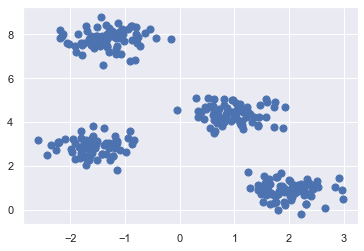

In [9]:
from sklearn.datasets import make_blobs

num_centroids = 4
x_train, y_train_true = make_blobs(n_samples=300, 
                                   centers=num_centroids, 
                                   cluster_std=0.4, 
                                   random_state=0)
plt.scatter(x_train[:, 0], x_train[:, 1], s=50)

Use sklearn's K-means algorithm to fit the data.

In [10]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=num_centroids)
kmeans.fit(x_train)
y_kmeans = kmeans.predict(x_train)

Now visualise the result.

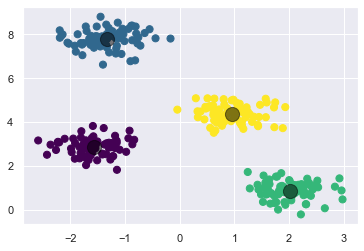

In [12]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

## K-means for anomaly detection

Now that K-means has been introduced, we can explore how this can be used for anomaly detection. Below two new clusters have been added that weren't part of the training. For the sake of this example we can call these anomalies. We can visually separate on of these clusters, but the otther one overlaps slightly with one of our training clusters.

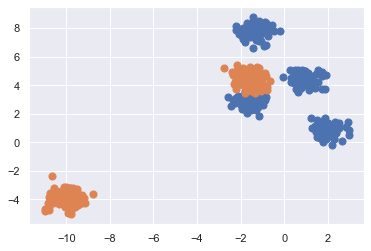

In [13]:
x_anomaly, y_anomaly_true = make_blobs(n_samples=300, 
                                       centers=2, 
                                       cluster_std=0.4,
                                       random_state=1)
plt.scatter(x_train[:, 0], x_train[:, 1], s=50)
plt.scatter(x_anomaly[:, 0], x_anomaly[:, 1], s=50)

First calculate the distances from each datapoint to its closest cluster center and then calculate the 99 percentile distance for each center that was observed in the training data. These distances act like a boundary, beyond which datapoints may be classes as anomilies.

In [19]:
percentile_threshold = 90

train_distances = kmeans.transform(x_train)
center_distances = {k: [] for k in range(num_centroids)}
for i in range(len(y_kmeans)):
    min_distance = train_distances[i][y_kmeans[i]]
    center_distances[y_kmeans[i]].append(min_distance)
    
percentile_distances = {
    k: np.percentile(
        center_distances[k], 
        percentile_threshold) for k in center_distances.keys()}

print(percentile_distances)

{0: 0.8052998798288775, 1: 0.8789978938977879, 2: 0.8422082855725942, 3: 0.8833787903003201}


Now plot these boundaries on our training data. The points in yellow are the points that are beinig classified as abnormal.

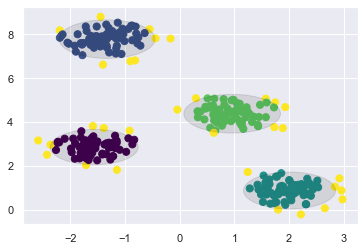

In [20]:
fig, ax = plt.subplots()

colors = []
for i in range(len(x_train)):
    min_distance = train_distances[i][y_kmeans[i]]
    if (min_distance > percentile_distances[y_kmeans[i]]):
        colors.append(4)
    else:
        colors.append(y_kmeans[i])
        
ax.scatter(x_train[:, 0], x_train[:, 1], c=colors, s=50, cmap='viridis')

for i in range(len(centers)):
    circle = plt.Circle((centers[i][0], centers[i][1]), 
                        percentile_distances[i], 
                        color='black', 
                        alpha=0.1)
    ax.add_artist(circle)

Now incorporate the abnormal test data to see how it is classified.

Normal datapoints misclassified as abnormal:  32
Abnormal datapoints misclassified as normal:  3


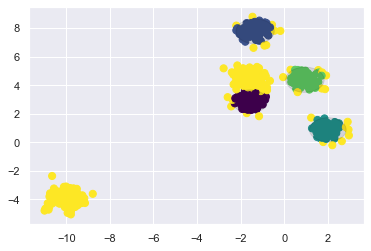

In [21]:
fig, ax = plt.subplots()

anomaly_distances = kmeans.transform(x_anomaly)
y_anomaly = kmeans.predict(x_anomaly)

combined_distances = [*train_distances, *anomaly_distances]
combined_y = [*y_kmeans, *y_anomaly]
all_data = np.array([*x_train, *x_anomaly])

false_negative = 0
false_positive = 0

colors = []
for i in range(len(all_data)):
    min_distance = combined_distances[i][combined_y[i]]
    if (min_distance > percentile_distances[combined_y[i]]):
        colors.append(4)
        false_positive += 1 if i < 300 else 0
            
    else:
        colors.append(combined_y[i])
        false_negative += 1 if i >= 300 else 0
        
ax.scatter(all_data[:, 0], all_data[:, 1], c=colors, s=50, cmap='viridis')

for i in range(len(centers)):
    circle = plt.Circle((centers[i][0], centers[i][1]), 
                        percentile_distances[i], 
                        color='black', 
                        alpha=0.1)
    ax.add_artist(circle)
    
print('Normal datapoints misclassified as abnormal: ', false_positive)
print('Abnormal datapoints misclassified as normal: ', false_negative)

Now we are able to classify abnormal data in a two dimensional space. The `percentile_threshold` variable can be adjusted to see how it impacts the number of false positives and false negatives.

## K-means on digits

First load a dataset of 64 pixel images of numerical digits. This is a much higher dimension of the 2D problem previously dealt with. It is decided that normal data is represented by 2-9, while abnormal data is represented by 0-1.

In [43]:
from sklearn.datasets import load_digits
digits = load_digits()

normal_data = []
abnormal_data = []
normal_label = []
abnormal_label = []
num_clusters = 8

for i in range(len(digits.target)):
    if digits.target[i] < 10 - num_clusters:
        abnormal_data.append(digits.data[i])
        abnormal_label.append(digits.target[i])
    else:
        normal_data.append(digits.data[i])
        normal_label.append(digits.target[i])

As before, find cluster centers.

In [44]:
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
clusters = kmeans.fit_predict(normal_data)

Visualise the centers of each cluster.

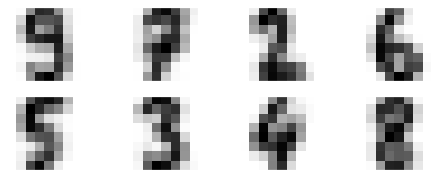

In [45]:
fig, ax = plt.subplots(2, int(num_clusters / 2), figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(num_clusters, 8, 8)
for a, c in zip(ax.flat, centers):
    a.set(xticks=[], yticks=[])
    a.imshow(c, interpolation='nearest', cmap=plt.cm.binary)

If we were to find the 99 percentile boundary for these clusters as in the previous example, we would get poor results. This is because K-means generally doesn't scale well with high dimensional problems. This is due to a relationship called the [Curse of Dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality) which states as the dimensionality increases, the volume of the space increases so fast that the available data becomes sparse.

Instead we can aim to reduce the dimensionality of the problem by projecting our data into a low dimensional space. We can use the t-distributed stochastic neighbour embedding algorithm (t-SNE) to do this, to pre-process the data before feeding it into K-means. The algorithm is commonly used to visualize high dimensional data. 

In [46]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

Now visualise our data projected onto a 2D space.

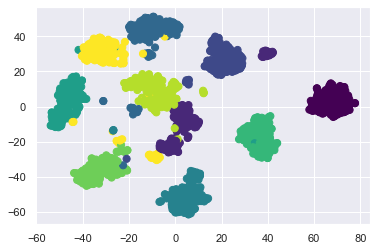

In [55]:
fig, ax = plt.subplots()
ax.scatter(digits_proj[:, 0], 
           digits_proj[:, 1], 
           c=digits.target,
           s=50,
           cmap='viridis')

Now separate the data into normal and abnormal data and run the k-means algorithm to calculate our percentage threshold as in the previous example.

In [58]:
normal_data = []
abnormal_data = []
normal_label = []
abnormal_label = []
num_clusters = 8

for i in range(len(digits.target)):
    if digits.target[i] < 10 - num_clusters:
        abnormal_data.append(digits_proj[i])
        abnormal_label.append(digits.target[i])
    else:
        normal_data.append(digits_proj[i])
        normal_label.append(digits.target[i])
        
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
clusters = kmeans.fit_predict(normal_data)

percentile_threshold = 99

normal_y = kmeans.predict(normal_data)
normal_distances = kmeans.transform(normal_data)
center_distances = {k: [] for k in range(num_clusters)}
for i in range(len(normal_y)):
    min_distance = normal_distances[i][normal_y[i]]
    center_distances[normal_y[i]].append(min_distance)
    
percentile_distances = {
    k: np.percentile(
        center_distances[k], 
        percentile_threshold) for k in center_distances.keys()}

print(percentile_distances)

{0: 22.70804353458512, 1: 14.023631262975563, 2: 12.415550981941728, 3: 13.926398532644116, 4: 15.350284027268364, 5: 12.809132316768505, 6: 21.15113412141011, 7: 11.684973512070727}


Finally calculate the distances of our abnormal data to our cluster centers, then calculate the number of false negatives and false positives and plot the data.

Normal datapoints misclassified as abnormal:  17
Abnormal datapoints misclassified as normal:  57


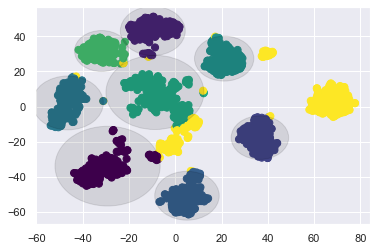

In [59]:
abnormal_y = kmeans.predict(abnormal_data)
abnormal_distances = kmeans.transform(abnormal_data)

combined_distances = [*normal_distances, *abnormal_distances]
combined_y = [*normal_y, *abnormal_y]
normal_data_length = len(normal_data)
all_data = np.array([*normal_data, *abnormal_data])

false_negatives = 0
false_positives = 0
colors = []
for i in range(len(all_data)):
    min_distance = combined_distances[i][combined_y[i]]
    if (min_distance > percentile_distances[combined_y[i]]):
        colors.append(10)
        false_positives += 1 if i < normal_data_length else 0
    else:
        colors.append(combined_y[i])
        false_negatives += 1 if i >= normal_data_length else 0

fig, ax = plt.subplots()
ax.scatter(all_data[:, 0], 
           all_data[:, 1], 
           c=colors, s=50, 
           cmap='viridis')

centers = kmeans.cluster_centers_
for i in range(len(centers)):
    circle = plt.Circle((centers[i][0], centers[i][1]), 
                        percentile_distances[i], color='black', 
                        alpha=0.1)
    ax.add_artist(circle)

print('Normal datapoints misclassified as abnormal: ', false_positives)
print('Abnormal datapoints misclassified as normal: ', false_negatives)

We have successfully been able to classify a number of abnormal digits correctly. However, while the dimensioniality reduction can be a powerful tool, it's not always a viable option. t-SNE can take a long time to run and won't always produce useful results.